# KNN Project Exercise 

KNN Classification using a PipeLine and a GridSearchCV tool.


## The Sonar Data 

### Detecting a Rock or a Mine

The data set contains the response metrics for 60 separate sonar frequencies sent out against a known mine field (and known rocks). These frequencies are then labeled with the known object they were beaming the sound at (either a rock or a mine). 



Our main goal is to create a machine learning model capable of detecting the difference between a rock or a mine based on the response of the 60 separate sonar frequencies.


Data Source: https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)


In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report

In [43]:
df = pd.read_csv('../DATA/sonar.all-data.csv')

In [44]:
df.head()

Freq_1  Freq_2  Freq_3  Freq_4  Freq_5  Freq_6  Freq_7  Freq_8  Freq_9  \
0  0.0200  0.0371  0.0428  0.0207  0.0954  0.0986  0.1539  0.1601  0.3109   
1  0.0453  0.0523  0.0843  0.0689  0.1183  0.2583  0.2156  0.3481  0.3337   
2  0.0262  0.0582  0.1099  0.1083  0.0974  0.2280  0.2431  0.3771  0.5598   
3  0.0100  0.0171  0.0623  0.0205  0.0205  0.0368  0.1098  0.1276  0.0598   
4  0.0762  0.0666  0.0481  0.0394  0.0590  0.0649  0.1209  0.2467  0.3564   

   Freq_10  ...  Freq_52  Freq_53  Freq_54  Freq_55  Freq_56  Freq_57  \
0   0.2111  ...   0.0027   0.0065   0.0159   0.0072   0.0167   0.0180   
1   0.2872  ...   0.0084   0.0089   0.0048   0.0094   0.0191   0.0140   
2   0.6194  ...   0.0232   0.0166   0.0095   0.0180   0.0244   0.0316   
3   0.1264  ...   0.0121   0.0036   0.0150   0.0085   0.0073   0.0050   
4   0.4459  ...   0.0031   0.0054   0.0105   0.0110   0.0015   0.0072   

   Freq_58  Freq_59  Freq_60  Label  
0   0.0084   0.0090   0.0032      R  
1   0.0049   0.0052   0.0044      R  
2   0.0164   0.0095   0.0078      R  
3   0.0044   0.0040   0.0117      R  
4   0.0048   0.0107   0.0094      R  

[5 rows x 61 columns]

## EDA

<AxesSubplot:>

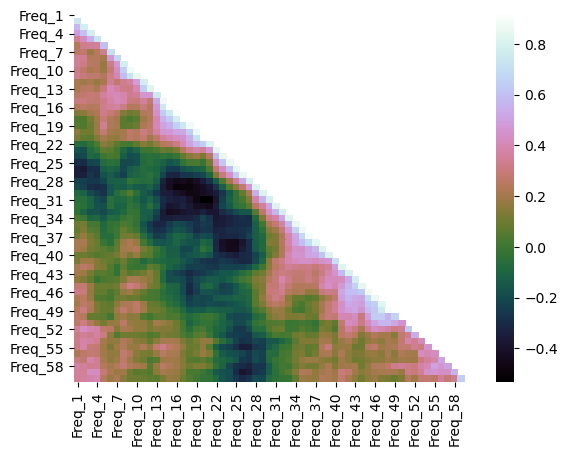

In [45]:
corr= df.corr()

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

# using the upper triangle matrix as mask 
sns.heatmap(corr, mask=matrix, cmap='cubehelix')

**What are the top 5 correlated frequencies with the target\label?**

In [46]:
# function to encode target column 
def encode(val):
    if val == 'R':
        return 0
    else:
        return 1

In [47]:
# create a new column that maps 0 or 1 based on Label feature
df['Encoded_Label'] = df['Label'].apply(lambda x: encode(x))

In [48]:
# retrieve correlations for the new Encoded Label column using iloc[:,-1]
# apply lambda fx that gets absolute values and retrieve top 5 correlated freqs
df.corr().iloc[:,-1].apply(lambda x: abs(x)).sort_values().tail(6)

Freq_45          0.339406
Freq_10          0.341142
Freq_49          0.351312
Freq_12          0.392245
Freq_11          0.432855
Encoded_Label    1.000000
Name: Encoded_Label, dtype: float64

In [49]:
# Alternative: Using the map function
# df['Target_2'] = df['Label'].map({'R':0,'M':1})
# np.abs(df.corr()['Target 2']).sort_values().tail(5)

**Split the data into features and labels, and then split into a training set and test set, with 90% for Cross-Validation training, and 10% for a final test set.**

In [50]:
df.columns

Index(['Freq_1', 'Freq_2', 'Freq_3', 'Freq_4', 'Freq_5', 'Freq_6', 'Freq_7',
       'Freq_8', 'Freq_9', 'Freq_10', 'Freq_11', 'Freq_12', 'Freq_13',
       'Freq_14', 'Freq_15', 'Freq_16', 'Freq_17', 'Freq_18', 'Freq_19',
       'Freq_20', 'Freq_21', 'Freq_22', 'Freq_23', 'Freq_24', 'Freq_25',
       'Freq_26', 'Freq_27', 'Freq_28', 'Freq_29', 'Freq_30', 'Freq_31',
       'Freq_32', 'Freq_33', 'Freq_34', 'Freq_35', 'Freq_36', 'Freq_37',
       'Freq_38', 'Freq_39', 'Freq_40', 'Freq_41', 'Freq_42', 'Freq_43',
       'Freq_44', 'Freq_45', 'Freq_46', 'Freq_47', 'Freq_48', 'Freq_49',
       'Freq_50', 'Freq_51', 'Freq_52', 'Freq_53', 'Freq_54', 'Freq_55',
       'Freq_56', 'Freq_57', 'Freq_58', 'Freq_59', 'Freq_60', 'Label',
       'Encoded_Label'],
      dtype='object')

In [51]:
X = df.drop(['Label','Encoded_Label'],axis=1)
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=42)

**PipeLine that contains both a StandardScaler and a KNN model**

Create pipeline w/ scaler and model instances &rarr; place pipeline in gridsearchcv with param grid

In [52]:
# create instances. Scaler is important for KNN since a distance metric is used.
scaler = StandardScaler()
knn = KNeighborsClassifier()

In [53]:
# name steps of pipeline and the associated instances to implement
operations = [('scaler',scaler),('knn',knn)]

In [54]:
# intitiate pipeline instance with list of steps as tuples
pipe = Pipeline(operations)

In [55]:
# not necessary: this retrieves the steps and instances in a pipeline
pipe.named_steps

{'scaler': StandardScaler(), 'knn': KNeighborsClassifier()}

**Grid-search with the pipeline to test various values of k (number of closest neighbors to consider in same group) and find best values.**

In [56]:
# creates a list of k values to check
k_values = list(range(1,30))

In [57]:
param_grid = {'knn__n_neighbors':k_values}

In [58]:
grid_model = GridSearchCV(pipe,cv=5,param_grid=param_grid,scoring='accuracy')

In [59]:
grid_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29]},
             scoring='accuracy')

In [60]:
grid_model.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=1))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=1),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 1,
 'knn__p': 2,
 'knn__weights': 'uniform'}

**A plot of the mean test scores per K value.**

In [61]:
grid_model.cv_results_['mean_test_score']

array([0.84537696, 0.78065434, 0.77524893, 0.75917496, 0.75931721,
       0.74822191, 0.75945946, 0.71664296, 0.7113798 , 0.68421053,
       0.70042674, 0.68435277, 0.68449502, 0.67908962, 0.69530583,
       0.68990043, 0.7113798 , 0.70042674, 0.72204836, 0.67908962,
       0.70071124, 0.69530583, 0.69530583, 0.68463727, 0.68477952,
       0.67923186, 0.67411095, 0.65775249, 0.6685633 ])

Text(0.5, 1.0, 'Mean Test Score per K Value')

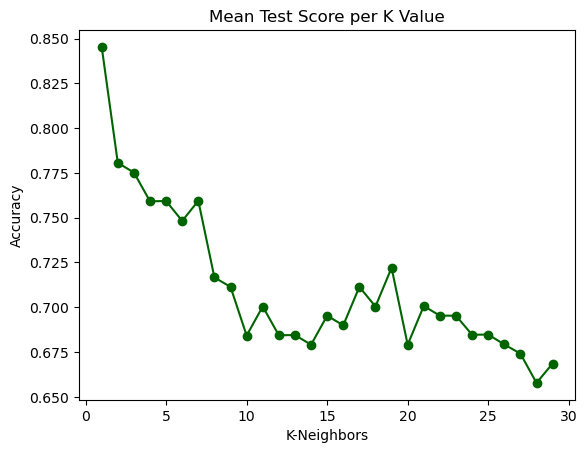

In [62]:
plt.plot(range(1,30),grid_model.cv_results_['mean_test_score'],marker='o',color='darkgreen')
plt.xlabel('K-Neighbors')
plt.ylabel('Accuracy')
plt.title('Mean Test Score per K Value')

The grid search chose a distance of **k=1** as the best setting for optimizing classification performance.

### Final Model Evaluation

**Final performance classification report and confusion matrix.**

In [63]:
y_pred = grid_model.predict(X_test)

In [64]:
confusion_matrix(y_test,y_pred)

array([[12,  1],
       [ 1,  7]], dtype=int64)

In [65]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           M       0.92      0.92      0.92        13
           R       0.88      0.88      0.88         8

    accuracy                           0.90        21
   macro avg       0.90      0.90      0.90        21
weighted avg       0.90      0.90      0.90        21



The model reports only one false negative and one false positive; precision and recall are close to 1.